In [1]:
import numpy as np
import matplotlib.pyplot as plt
import commsim.tx as tx
import commsim.rx as rx
import commsim.channel as ch
import commsim.equaliser as eq
import commsim.simulation as sim

In [2]:
# Load the measured channel impulse response
audio_imp = np.loadtxt("50-channel-impulse.npz")

In [54]:
Fc = 11000# carrier frequency
Fs = 44000 # audio sampling frequency
Df = 50 # Data rate = Fs/Df
M = 4
f0 = 200 # frequency offset
snr = 100

q4mod = tx.QAM_SymbolMod(4)
q4demod = rx.QAM_SymbolDemod(4)
BPSKmod = tx.PSK_SymbolMod(2)
BPSKdemod = rx.PSK_SymbolDemod(2)

rrc_pf = tx.RRCPulseFilter(0.35, Df, Df*5)
# rect_pf
lp = rx.LP_Filter(np.arange(0,1000,100), 2000, order=5, Fs=Fs)

mod = q4mod    # modulation defined here 
demod = q4demod # demodulation defined here

# Channels
TD_ch = ch.TimeDelay_Channel(delay=0.5)
FO_ch = ch.FrequencyOffset_Channel(f0,Fs)
AWGN_ch = ch.AWGN_Channel(snr)
audio_ch = ch.Custom_Channel("audio channel", audio_imp)
wireless_ch = ch.Custom_Channel("wireless channel", np.array([1/2, 1/4, 0, 1/4]))


cfs = rx.CoarseFreqSync(mod, Fs) 
sbs = rx.SymbolSync(demod, rrc_pf, Kp=0.3)
cs = rx.FineFreqSync(demod, fs=Fs, alpha=0.132, beta=0.009)
# cs = rx.CarrierSync(Kp=0.03)

# equaliser = eq.MMSE_Equaliser(snr, gL=15, K=50)
equaliser = eq.ZF_Equaliser(gL=15, K=50)

commsim = sim.CommSim(mod,  demod,\
                        rrc_pf, \
                        #[audio_ch, AWGN_ch, TD_ch], \
                        #[TD_ch, AWGN_ch], \
                        [audio_ch, AWGN_ch],
                        lp,\
                        cfs,\
                        sbs,\
                        cs,\
                        eq=equaliser, \
                        fc=Fc, fs=Fs)

Coarse Frequency Shift(Hz):  -199.9881300941679
Carrier Phase Compensation(radian):  -1.6939882172922829
[0 0 0 2 2 0 3 0 0 2]
[0 0 0 2 2 0 3 0 0 2]
Error Rate:  0.0
Peak at  -799.9525203766716  Hz


0.0

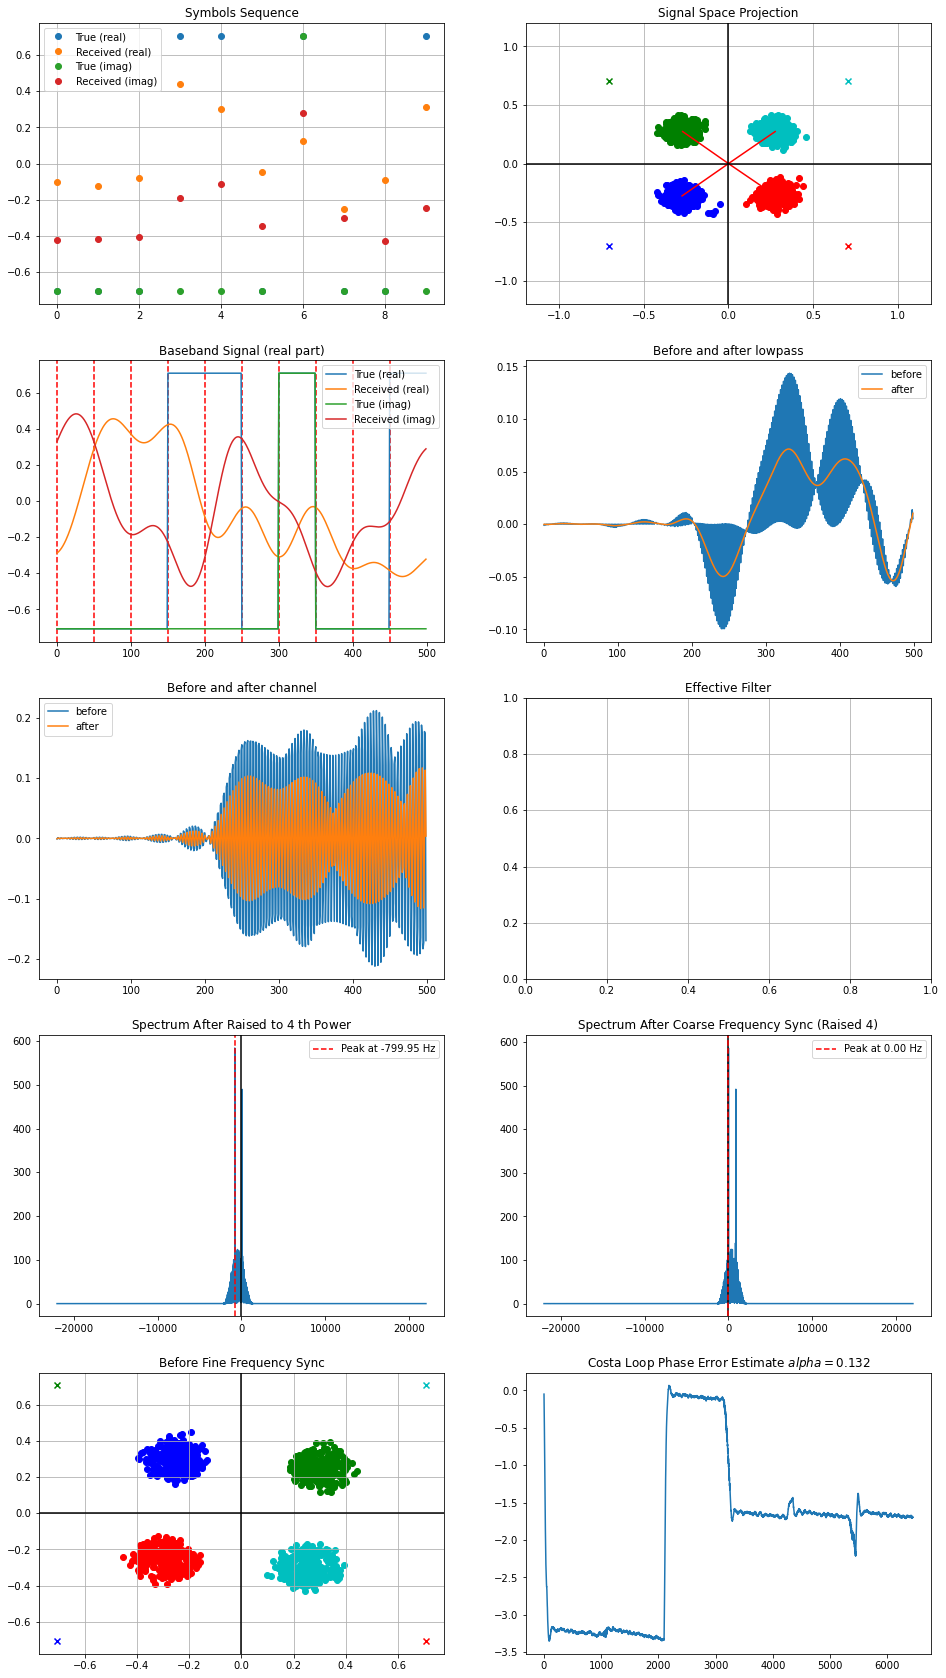

In [60]:
n = 1000
data = np.random.randint(mod.M, size=n)
pre_data = np.random.randint(mod.M, size=100)
commsim.transmit(pre_data, f0=f0, cfs_enable=True,  sbs_enable=False, cs_enable=True, eq_enable=False, verbose=False, preamble=True) # preamble transmission
commsim.transmit(data, f0=f0, cfs_enable=True,  sbs_enable=False, cs_enable=True, eq_enable=False, verbose=True, preamble=False)

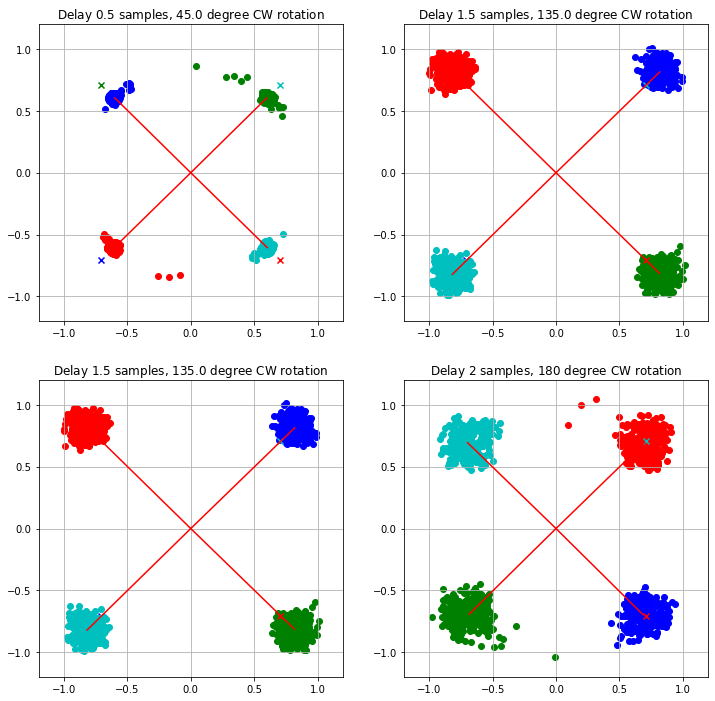

In [5]:
# drawing the delay graph
n = 1000
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
colors = ['b','g','r','c']
data = np.random.randint(mod.M, size=n)
for idx, delay in enumerate([0.5, 1.5, 1.5, 2]):
    TD_ch = ch.TimeDelay_Channel(delay=delay)
    commsim.channels[0] = TD_ch
    commsim.transmit(data, f0=0, cfs_enable=False,  sbs_enable=False, cs_enable=True, eq_enable=False, verbose=False, preamble=False)
    commsim.d_true = data
    r = 0 if idx < 2 else 1
    c = idx % 2
    yr = commsim.y_cs.real
    yi = commsim.y_cs.imag
    for i in range(commsim.mod.M):
        d_true = commsim.d_true
        ax[r][c].scatter(yr[d_true==i], yi[d_true==i], color=colors[i])
        ax[r][c].scatter(commsim.mod.symbols[i].real, commsim.mod.symbols[i].imag, marker='x', color=colors[i])
        pred_center = np.mean(yr[d_true==i]) + 1j*np.mean(yi[d_true==i])
        ax[r][c].plot([0, pred_center.real], [0, pred_center.imag], '-r')
        ax[r][c].set_xlim(-1.2, 1.2)
        ax[r][c].set_ylim(-1.2, 1.2)
        ax[r][c].grid(True)
        ax[r][c].set_title(f"Delay ${delay}$ samples, ${90*delay}$ degree CW rotation")

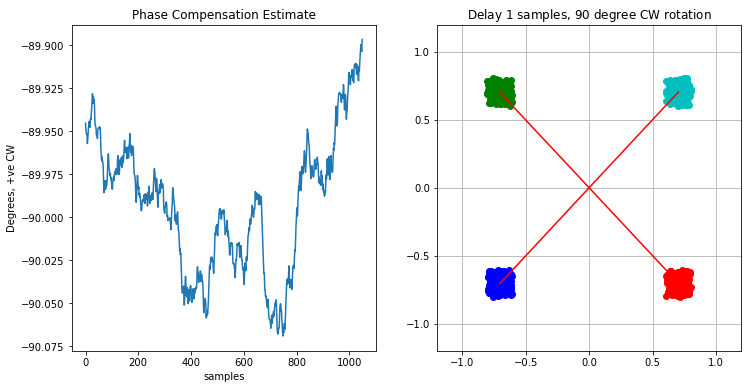

In [45]:
# drawing the delay graph
n = 1000
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
colors = ['b','g','r','c']
data = np.random.randint(mod.M, size=n)
phi_log = []
pre_data = np.random.randint(mod.M, size=50)
commsim.cs.phi_log = []
commsim.cs.alpha = 0.001
commsim.cs.beta = 0
for idx, delay in enumerate([1]):
    TD_ch = ch.TimeDelay_Channel(delay=delay)
    commsim.channels[0] = TD_ch
    commsim.transmit(pre_data, f0=0, cfs_enable=False,  sbs_enable=False, cs_enable=True, eq_enable=False, verbose=False, preamble=True)
    # ax[0].plot(np.array(commsim.cs.phi_log)/np.pi*180)
    commsim.transmit(data, f0=0, cfs_enable=False,  sbs_enable=False, cs_enable=True, eq_enable=False, verbose=False, preamble=False)
    commsim.d_true = data
    ax[0].plot(np.array(commsim.cs.phi_log)/np.pi*180)
    ax[0].set_title("Phase Compensation Estimate")
    ax[0].set_xlabel("samples")
    ax[0].set_ylabel("Degrees, +ve CW")
    
    yr = commsim.y_cs.real
    yi = commsim.y_cs.imag
    for i in range(commsim.mod.M):
        d_true = commsim.d_true
        ax[1].scatter(yr[d_true==i], yi[d_true==i], color=colors[i])
        ax[1].scatter(commsim.mod.symbols[i].real, commsim.mod.symbols[i].imag, marker='D', color=colors[i])
        pred_center = np.mean(yr[d_true==i]) + 1j*np.mean(yi[d_true==i])
        ax[1].plot([0, pred_center.real], [0, pred_center.imag], '-r')
        ax[1].set_xlim(-1.2, 1.2)
        ax[1].set_ylim(-1.2, 1.2)
        ax[1].grid(True)
        ax[1].set_title(f"Delay ${delay}$ samples, ${90*delay}$ degree CW rotation")

[]

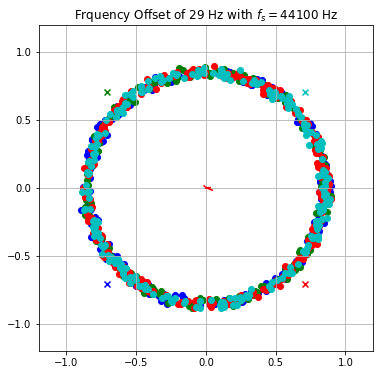

In [11]:
commsim.transmit(data, f0=29, cfs_enable=False,  sbs_enable=False, cs_enable=False, eq_enable=False, verbose=False, preamble=False)
yr = commsim.demod_symbol.real
yi = commsim.demod_symbol.imag
d_true = commsim.d_true
plt.figure(figsize=(6,6))
for i in range(commsim.mod.M):
    plt.scatter(yr[d_true==i], yi[d_true==i], color=colors[i])
    plt.scatter(commsim.mod.symbols[i].real, commsim.mod.symbols[i].imag, marker='x', color=colors[i])
    pred_center = np.mean(yr[d_true==i]) + 1j*np.mean(yi[d_true==i])
    plt.plot([0, pred_center.real], [0, pred_center.imag], '-r')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.grid(True)
plt.title(f"Frquency Offset of $29$ Hz with $f_s=44100$ Hz")
plt.plot()

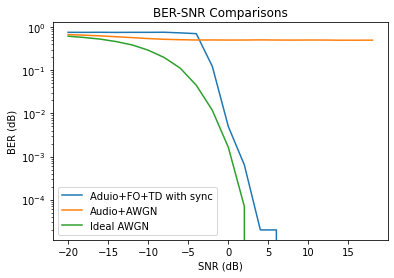

In [64]:
Fc = 11000# carrier frequency
Fs = 44000 # audio sampling frequency
Df = 20 # Data rate = Fs/Df
M = 4
f0 = 300 # frequency offset
snr = 0

q4mod = tx.QAM_SymbolMod(4)
q4demod = rx.QAM_SymbolDemod(4)
BPSKmod = tx.PSK_SymbolMod(2)
BPSKdemod = rx.PSK_SymbolDemod(2)

rrc_pf = tx.RRCPulseFilter(0.35, Df, Df*5)
# rect_pf
lp = rx.LP_Filter(np.arange(0,1000,100), 2000, order=5, Fs=Fs)

mod = q4mod    # modulation defined here 
demod = q4demod # demodulation defined here

# Channels
TD_ch = ch.TimeDelay_Channel(delay=0.3)
FO_ch = ch.FrequencyOffset_Channel(f0,Fs)
AWGN_ch = ch.AWGN_Channel(snr)
audio_ch = ch.Custom_Channel("audio channel", audio_imp)
wireless_ch = ch.Custom_Channel("wireless channel", np.array([1/2, 1/4, 0, 1/4]))


cfs = rx.CoarseFreqSync(mod, Fs) 
sbs = rx.SymbolSync(demod, rrc_pf, Kp=0.3)
cs = rx.FineFreqSync(demod, fs=Fs, alpha=0.132, beta=0.009)
equaliser = eq.ZF_Equaliser(gL=15, K=50)

n = 10000# inital data length



error_rate1 = []
error_rate2 = []
error_rate3 = []
error1 = 0
error2 = 0
error3 = 0

snrs = np.arange(-20, 20, 2)
# snrs = []

for snr in snrs:
    error1 = 0
    error2 = 0
    error3 = 0
    for i in range(10):
        pre_data = np.random.randint(mod.M, size=100)
        data = np.random.randint(mod.M, size=n)
        AWGN_ch.snr = snr
        commsim = sim.CommSim(mod,  demod,\
                        rrc_pf, \
                        [audio_ch, AWGN_ch, TD_ch], \
                        lp,\
                        cfs,\
                        sbs,\
                        cs,\
                        eq=equaliser, \
                        fc=Fc, fs=Fs)
        commsim.transmit(pre_data, f0=f0, cfs_enable=True,  sbs_enable=False, cs_enable=True, eq_enable=False, verbose=False, preamble=True)
        error1 += commsim.transmit(data, f0=f0, cfs_enable=True,  sbs_enable=False, cs_enable=True, eq_enable=False, verbose=False, preamble=False)
   
        commsim = sim.CommSim(mod,  demod, rrc_pf, [audio_ch, AWGN_ch],lp, cfs, sbs, cs, eq=equaliser, fc=Fc, fs=Fs)
        error2 += commsim.transmit(data, f0=0, cfs_enable=False,  sbs_enable=False, cs_enable=False, eq_enable=False, verbose=False, preamble=False)
    
        commsim = sim.CommSim(mod,  demod, rrc_pf, [AWGN_ch],lp, cfs, sbs, cs, eq=equaliser, fc=Fc, fs=Fs)
        error3 += commsim.transmit(data, f0=0, cfs_enable=False,  sbs_enable=False, cs_enable=False, eq_enable=False, verbose=False, preamble=False)
        
    error_rate1.append(error1/10)
    error_rate2.append(error2/10)
    error_rate3.append(error3/10)

plt.semilogy(snrs, error_rate1, label="Aduio+FO+TD with sync")
plt.semilogy(snrs, error_rate2, label="Audio+AWGN")
plt.semilogy(snrs, error_rate3, label="Ideal AWGN")



plt.xlabel('SNR (dB)')
plt.ylabel('BER (dB)')
plt.title('BER-SNR Comparisons')
plt.legend()
plt.show()
        

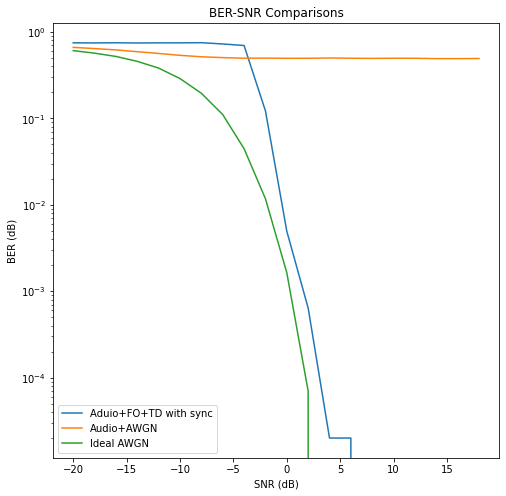

In [65]:
plt.figure(figsize=(8,8))
plt.semilogy(snrs, error_rate1, label="Aduio+FO+TD with sync")
plt.semilogy(snrs, error_rate2, label="Audio+AWGN")
plt.semilogy(snrs, error_rate3, label="Ideal AWGN")



plt.xlabel('SNR (dB)')
plt.ylabel('BER (dB)')
plt.title('BER-SNR Comparisons')
plt.legend()
plt.show()

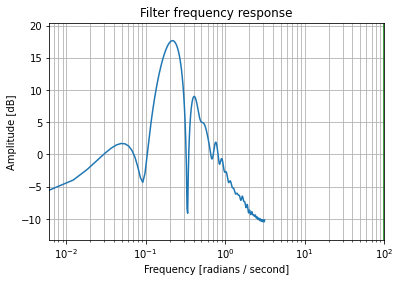

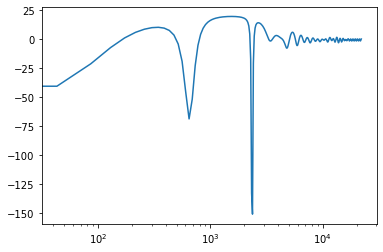

In [37]:
import scipy.signal as signal
wireless_imp = np.array([1/2, 1/2])
w, h = signal.freqz(audio_imp, [1])
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

w, gd = signal.group_delay((audio_imp,[1]), fs=Fs) # compute delay
plt.semilogx(w, gd)
plt.show()

In [12]:
import pyaudio
def play_sound_array(sound, volumn=1.0, fs=44100):
    """This function has bug. Will not play the whole array"""
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=fs,
                    output=True)
    stream.write( (volumn*sound).tobytes() )
   
    stream.stop_stream()
    stream.close()
    p.terminate()

In [14]:
play_sound_array(commsim.x_pass) # okay this doesn't sound too beautiful...